In [1]:
!pip install sentinelsat
!pip install geopandas
!pip install rasterio
!pip install folium

     |████████████████████████████████| 51kB 3.7MB/s 
     |████████████████████████████████| 1.0MB 14.4MB/s 
     |████████████████████████████████| 15.4MB 262kB/s 
     |████████████████████████████████| 6.6MB 33.7MB/s 
     |████████████████████████████████| 19.3MB 1.4MB/s 


In [2]:
from sentinelsat import SentinelAPI
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import getpass
import geopandas as gpd
import folium 
import fiona
import rasterio
import rasterio.mask
import os
import skimage
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Login to Sentinel-2

In [3]:
user = input("Username:")
password = getpass.getpass('Password:')
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')
user,password = '','' # remove variables

Username:sjiang32
Password:··········


#Load Shapefile

In [71]:
NYC_shape = gpd.read_file('/content/drive/MyDrive/NYCdata/NYC_SHP2.shp')
nyc = folium.Map(location=[40.6575,-73.8857],zoom_start=13)
folium.GeoJson(NYC_shape).add_to(nyc)
nyc

#Querying Sentinel-2 Product based on shape file

In [21]:
footprint = geojson_to_wkt(read_geojson('/content/drive/MyDrive/NYCdata/nyc_shape.json'))
# querying the data
products = api.query(footprint,
                     date = ('20191101', '20201101'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,0.5)
                    )

In [22]:
products_df = api.to_dataframe(products)
products_df.head(5)

,title,link,link_alternative,link_icon,summary,ondemand,beginposition,endposition,ingestiondate,orbitnumber,relativeorbitnumber,vegetationpercentage,notvegetatedpercentage,waterpercentage,unclassifiedpercentage,mediumprobacloudspercentage,highprobacloudspercentage,snowicepercentage,cloudcoverpercentage,level1cpdiidentifier,gmlfootprint,footprint,format,processingbaseline,platformname,filename,instrumentname,instrumentshortname,size,s2datatakeid,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,identifier,uuid
270459d9-252d-4a57-ab86-f42f82843972,S2A_MSIL2A_20201017T155251_N0214_R054_T18TWL_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2020-10-17T15:52:51.024Z, Instrument: MS...",false,2020-10-17 15:52:51.024,2020-10-17 15:52:51.024,2020-10-18 00:51:24.071,27793,54,79.765254,8.271509,6.210702,1.176771,0.070524,0.309463,0.001543,0.421761,S2A_OPER_MSI_L1C_TL_VGS2_20201017T193914_A0277...,"<gml:Polygon srsName=""http://www.opengis.net/g...","MULTIPOLYGON (((-73.8201 40.55612818801274, -7...",SAFE,02.14,Sentinel-2,S2A_MSIL2A_20201017T155251_N0214_R054_T18TWL_2...,Multi-Spectral Instrument,MSI,1.11 GB,GS2A_20201017T155251_027793_N02.14,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_MSIL2A_20201017T155251_N0214_R054_T18TWL_2...,270459d9-252d-4a57-ab86-f42f82843972
a0bed006-c610-4353-be31-f6db0165d159,S2A_MSIL2A_20201017T155251_N0214_R054_T18TXL_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2020-10-17T15:52:51.024Z, Instrument: MS...",false,2020-10-17 15:52:51.024,2020-10-17 15:52:51.024,2020-10-18 00:50:49.700,27793,54,80.326635,4.992813,10.565376,1.141547,0.044723,0.095257,0.002495,0.313522,S2A_OPER_MSI_L1C_TL_VGS2_20201017T193914_A0277...,"<gml:Polygon srsName=""http://www.opengis.net/g...","MULTIPOLYGON (((-73.81879 40.55974178921592, -...",SAFE,02.14,Sentinel-2,S2A_MSIL2A_20201017T155251_N0214_R054_T18TXL_2...,Multi-Spectral Instrument,MSI,180.84 MB,GS2A_20201017T155251_027793_N02.14,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_MSIL2A_20201017T155251_N0214_R054_T18TXL_2...,a0bed006-c610-4353-be31-f6db0165d159
05a7381d-cd60-4dd1-9fb7-cc42c1ac4278,S2A_MSIL2A_20201014T154231_N0214_R011_T18TWL_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2020-10-14T15:42:31.024Z, Instrument: MS...",false,2020-10-14 15:42:31.024,2020-10-14 15:42:31.024,2020-10-15 00:32:53.428,27750,11,75.487649,11.465416,7.572580,1.467859,0.102857,0.370547,0.001624,0.473849,S2A_OPER_MSI_L1C_TL_VGS2_20201014T192755_A0277...,"<gml:Polygon srsName=""http://www.opengis.net/g...","MULTIPOLYGON (((-73.70337 40.5554731412015, -7...",SAFE,02.14,Sentinel-2,S2A_MSIL2A_20201014T154231_N0214_R011_T18TWL_2...,Multi-Spectral Instrument,MSI,1012.49 MB,GS2A_20201014T154231_027750_N02.14,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_MSIL2A_20201014T154231_N0214_R011_T18TWL_2...,05a7381d-cd60-4dd1-9fb7-cc42c1ac4278
4512cabd-6748-4152-a85b-9dac448042bb,S2A_MSIL2A_20201014T154231_N0214_R011_T18TXL_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2020-10-14T15:42:31.024Z, Instrument: MS...",false,2020-10-14 15:42:31.024,2020-10-14 15:42:31.024,2020-10-15 00:32:53.287,27750,11,52.381438,5.962381,38.545981,0.714251,0.099081,0.182561,0.001427,0.282252,S2A_OPER_MSI_L1C_TL_VGS2_20201014T192755_A0277...,"<gml:Polygon srsName=""http://www.opengis.net/g...","MULTIPOLYGON (((-72.5228 40.536185528423594, -...",SAFE,02.14,Sentinel-2,S2A_MSIL2A_20201014T154231_N0214_R011_T18TXL_2...,Multi-Spectral Instrument,MSI,1.01 GB,GS2A_20201014T154231_027750_N02.14,S2MSI2A,2015-028A,DESCENDING,Sent

#Find one online product

In [43]:
# Select one online sentinle image as test image.
for i in range(len(products_df.index)):
  product_id = products_df.index[i]
  product_info = api.get_product_odata(product_id)
  if product_info['Online'] == True:
   print(f"Detected {product_id} is online  -> Dataframe index {i} \nProduct Title -> {products_df.iloc[i].title}")
   break

Detected d53dfe68-e0b3-484f-a971-53f533c1552c is online  -> Dataframe index 20 
Product Title -> S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310


#Download the product

In [25]:
api.download(products_df.index[20])

{'Creation Date': datetime.datetime(2019, 11, 2, 23, 26, 13, 530000),
 'Ingestion Date': datetime.datetime(2019, 11, 2, 23, 25, 47, 943000),
 'Online': True,
 'date': datetime.datetime(2019, 11, 2, 15, 54, 21, 24000),
 'downloaded_bytes': 1177910413,
 'footprint': 'POLYGON((-73.69653 40.900752759239666,-73.71948 40.83741738772349,-73.772156 40.691352390255055,-73.82092 40.55613268849005,-75.000244 40.56274991351036,-75.000244 41.551844670066835,-73.68381 41.54431153543986,-73.69653 40.900752759239666))',
 'id': 'd53dfe68-e0b3-484f-a971-53f533c1552c',
 'md5': 'c14af4c453336ed280ea4a768c43b113',
 'path': 'S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310.zip',
 'quicklook_url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('d53dfe68-e0b3-484f-a971-53f533c1552c')/Products('Quicklook')/$value",
 'size': 1177910413,
 'title': 'S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('d53dfe68-e0b3-484f-a971

#Unzip the file

In [44]:
# unzip the file
%%bash
mv /content/S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310.zip /content/drive/MyDrive/S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310.zip
cd /content/drive/MyDrive
unzip -d /content/drive/MyDrive/S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310 S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310.zip

Archive:  S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310.zip
   creating: /content/drive/MyDrive/S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310/S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310.SAFE/
 extracting: /content/drive/MyDrive/S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310/S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310.SAFE/INSPIRE.xml  
   creating: /content/drive/MyDrive/S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310/S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310.SAFE/rep_info/
 extracting: /content/drive/MyDrive/S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310/S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310.SAFE/rep_info/S2_PDI_Level-2A_Tile_Metadata.xsd  
 extracting: /content/drive/MyDrive/S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310/S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310.SAFE/rep_info/S2_PDI_Level-2A_Datastrip_Metad

#Create RGB iamge

In [48]:
%mkdir /content/drive/MyDrive/Img
%cd ./drive/MyDrive/Img
%pwd

/content/drive/MyDrive/Img


'/content/drive/MyDrive/Img'

In [53]:
# open different bands files and write to RGB.tif file

R10 = '/content/drive/MyDrive/S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310/S2A_MSIL2A_20191102T155421_N0213_R054_T18TWL_20191102T201310.SAFE/GRANULE/L2A_T18TWL_A022788_20191102T155929/IMG_DATA/R10m'
b4 = rasterio.open(R10+'/T18TWL_20191102T155421_B04_10m.jp2') #Red
b3 = rasterio.open(R10+'/T18TWL_20191102T155421_B03_10m.jp2') #Green
b2 = rasterio.open(R10+'/T18TWL_20191102T155421_B02_10m.jp2') #Blue

file_name = 'T18TWL_20191102T155421_10m_RGB'
with rasterio.open(f'{file_name}.tif','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),1) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),3) 
    rgb.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


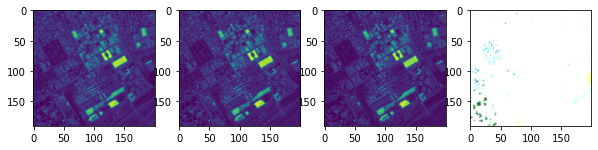

In [63]:
with fiona.open("../NYCdata/NYC_SHP2.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
with rasterio.open('T18TWL_20191102T155421_10m_RGB.tif') as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("RGB_NYC_Subset_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)
    dest.close()

img_path = 'RGB_NYC_Subset_masked.tif'
img = skimage.io.imread(img_path)
rgb = img[..., :3]
# elev = img[..., -1]
fig,ax = plt.subplots(1,4, figsize=(10,10))
ax[0].imshow(img[...,-1])
ax[1].imshow(img[...,-2])
ax[2].imshow(img[...,-3])
ax[3].imshow(img)

In [65]:
img.max()

8028

#Normalization

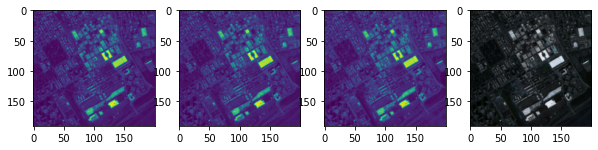

In [66]:
# Normalization
img_norm = (img - img.min()) * (1/(img.max() - img.min()))

fig,ax = plt.subplots(1,4, figsize=(10,10))
ax[0].imshow(img_norm[...,0])
ax[1].imshow(img_norm[...,1])
ax[2].imshow(img_norm[...,2])
ax[3].imshow(img_norm)

#Write the Normalized image

In [69]:
with rasterio.open('RGB_NYC_Subset_masked.tif') as src:
    out_meta = src.meta
out_meta.update({'dtype': 'float64'}) # since we normalized it to (0,1), int16 will genereat a sparse matrix

with rasterio.open("RGB_NYC_Subset_masked_normed.tif", "w",**out_meta) as dest:
    dest.write(np.moveaxis(img_norm, [0, 1, 2], [2, 1, 0])) # In rasterio the numpy array needs to be in bands, rows, cols order (z, y, x) not cols, rows, bands (x, y, z).
    dest.close()

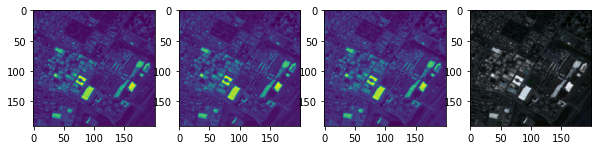

In [70]:
img_path = 'RGB_NYC_Subset_masked_normed.tif'
img = skimage.io.imread(img_path)
fig,ax = plt.subplots(1,4, figsize=(10,10))
ax[0].imshow(img[...,0])
ax[1].imshow(img[...,1])
ax[2].imshow(img[...,2])
ax[3].imshow(img)